# Michaelis_Menten Specific Visualization

In [1]:
import os
os.chdir("../")

In [2]:
import glob
import gzip
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from modelproblem import ModelProblem
from petab.visualize import plot_problem
from weighted_quantile import weighted_quantile
from result_classes import Result,MethodResults

In [3]:
prob_name = "Michaelis_Menten"
methods = ["ptmcmc", "smc", "pmc"]
colors = sns.color_palette("tab10", n_colors=len(methods))

mod_prob = ModelProblem(prob_name)
mod_prob.initialize()

grouped_results = [MethodResults(x) for x in methods]

for method, group_obj in zip(methods, grouped_results):
	result_dir = f"results/{prob_name}/{method}/"
	fnames = glob.glob(result_dir + "*.pkl")
	for fname in fnames:
		#print(fname)
		with gzip.open(fname, "rb") as f:
			results = pickle.load(f)
		result_obj = Result(results)
		group_obj.add_result(result_obj)
print(type(mod_prob.problem))		

<class 'pypesto.problem.base.Problem'>


Text(0, 0.5, 'Sampling Quality (log_k1)')

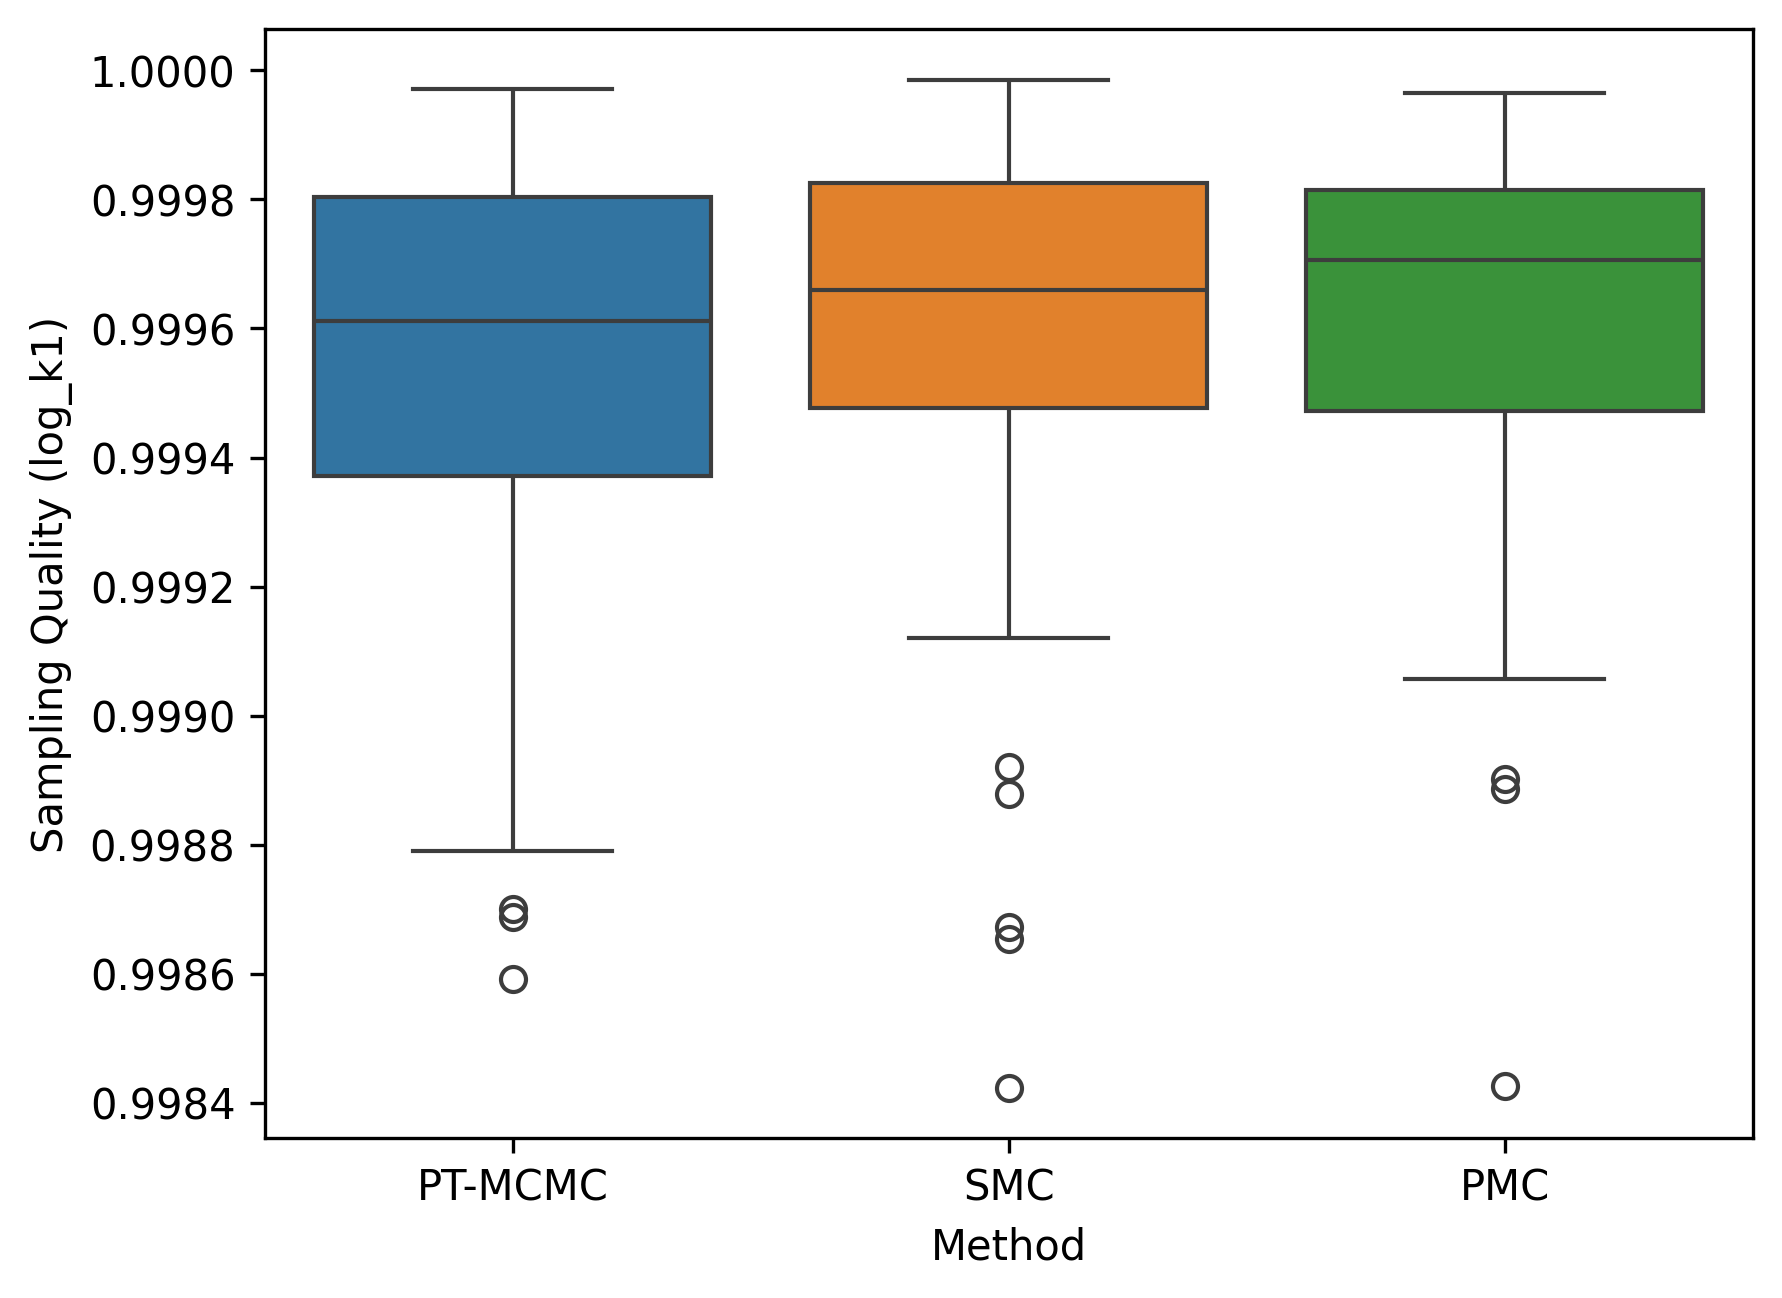

In [4]:
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]
par_bounds = mod_prob.bounds
plt.figure(dpi=300)
ratios = np.array([x.get_sampling_efficiency(par_bounds, 0) for x in grouped_results])
ratio_df = pd.DataFrame(columns=methods, data=ratios.T)

sns.boxplot(ratio_df)#, size=2)
plt.xticks(range(len(methods)), [x.abbr for x in grouped_results])
plt.xlabel("Method"); plt.ylabel("Sampling Quality (log_k1)")
#plt.ylabel(f"% of Parameter Space Covered\nfor Parameter {fit_par_names[0]} ");

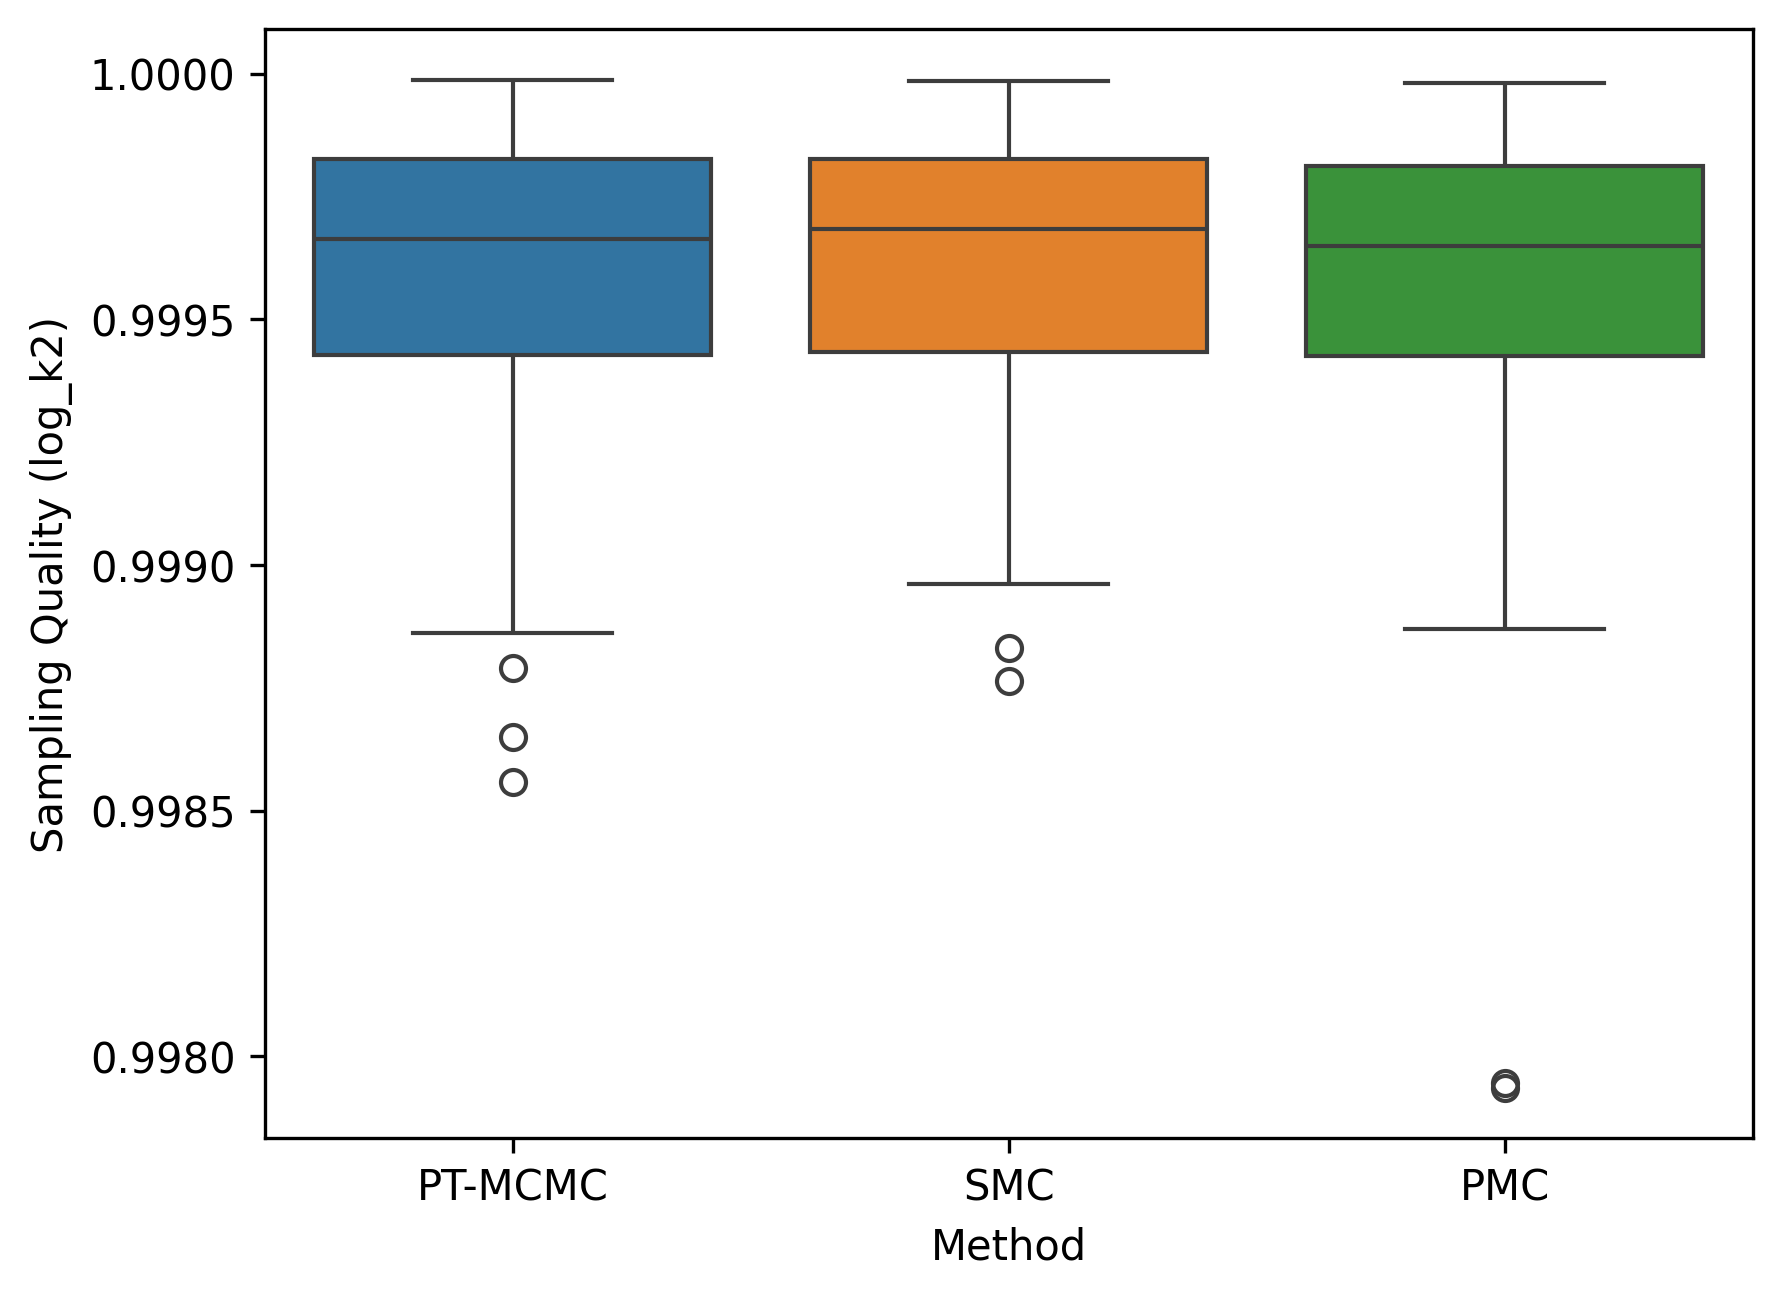

In [5]:
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]
par_bounds = mod_prob.bounds
plt.figure(dpi=300)
ratios = np.array([x.get_sampling_efficiency(par_bounds, 1) for x in grouped_results])
ratio_df = pd.DataFrame(columns=methods, data=ratios.T)

sns.boxplot(ratio_df)#, size=2)
plt.xticks(range(len(methods)), [x.abbr for x in grouped_results])
plt.xlabel("Method"); #plt.ylabel(f"% of Parameter Space Covered\nfor Parameter {fit_par_names[1]} ");
plt.ylabel("Sampling Quality (log_k2)");

/tmp/ipykernel_22977/1504559743.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,temp],ignore_index=True)


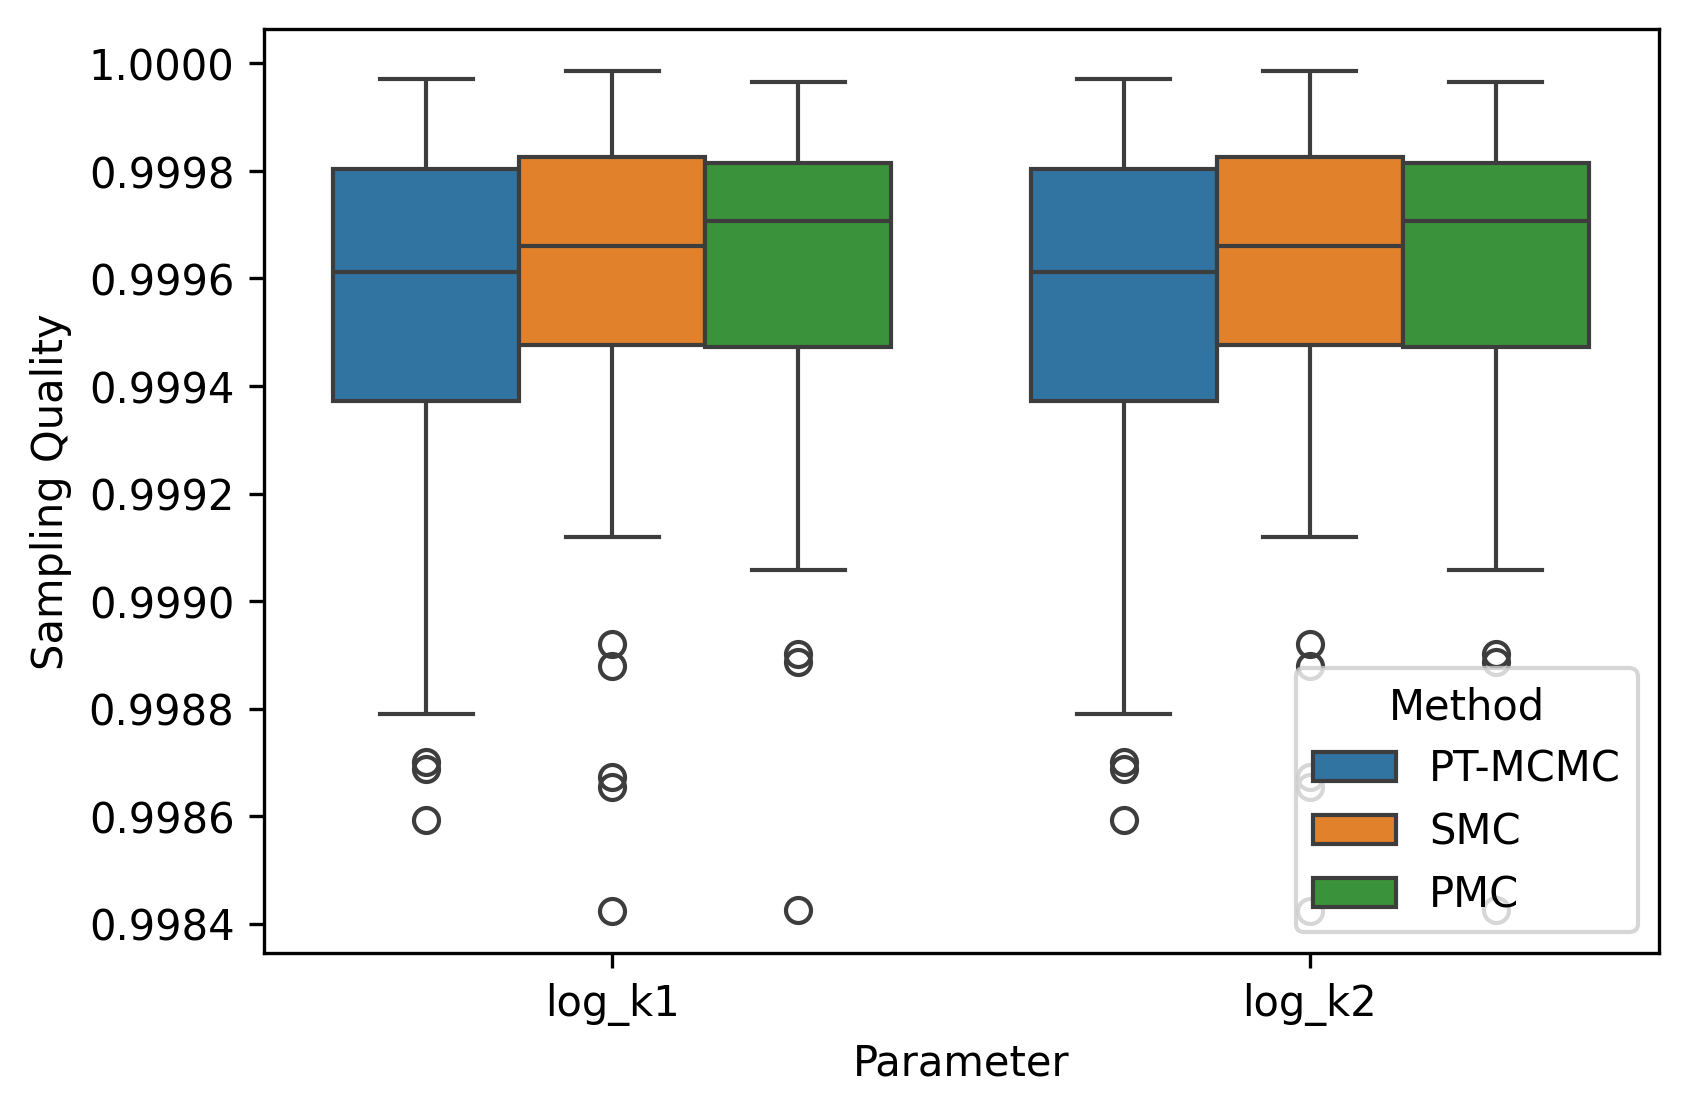

In [6]:

fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]
par_bounds = mod_prob.bounds
plt.figure(dpi=300, figsize=(6,4))

df = pd.DataFrame(columns=["Method", "Parameter", "Ratio"])
for i, group in enumerate(grouped_results):
	ratios = np.array(group.get_sampling_efficiency(par_bounds, 0))
	temp = pd.DataFrame({"Parameter":["log_k1"]*100, "Method":[group.abbr]*100,"Ratio":ratios})
	df = pd.concat([df,temp],ignore_index=True)
	ratios1 = np.array(group.get_sampling_efficiency(par_bounds, 1))
	temp1 = pd.DataFrame({"Parameter":["log_k2"]*100, "Method":[group.abbr]*100,"Ratio":ratios})
	df = pd.concat([df,temp1],ignore_index=True)


sns.boxplot(data=df, x="Parameter", y="Ratio", hue="Method")
#plt.xticks(range(len(methods)), [x.abbr for x in grouped_results])
#plt.xlabel("Method"); #plt.ylabel(f"% of Parameter Space Covered\nfor Parameter {fit_par_names[1]} ");
plt.ylabel("Sampling Quality");

## Select best result for each method

In [7]:
llhs = [x.get_avg_llhs() for x in grouped_results]
best_runs = [np.argmax(x) for x in llhs]
best_results = [res.all_runs[best_idx] for best_idx, res in zip(best_runs, grouped_results)]

### Compare SMC and PMC MCMC Sampling Efficiency

In [8]:
pmc_idx = methods.index("pmc")
pmc_best = best_results[pmc_idx]
u = pmc_best.algo_specific_info["acceptance"]
u

array([1.        , 1.        , 0.75154104, 0.7113943 , 0.7421337 ,
       0.68541835, 0.57055256, 0.44875623, 0.44138223, 0.44205533,
       0.24022133, 0.26260376, 0.21019763, 0.23583917, 0.24448959,
       0.24896871])

### Plot Gaussian mapping for PMC

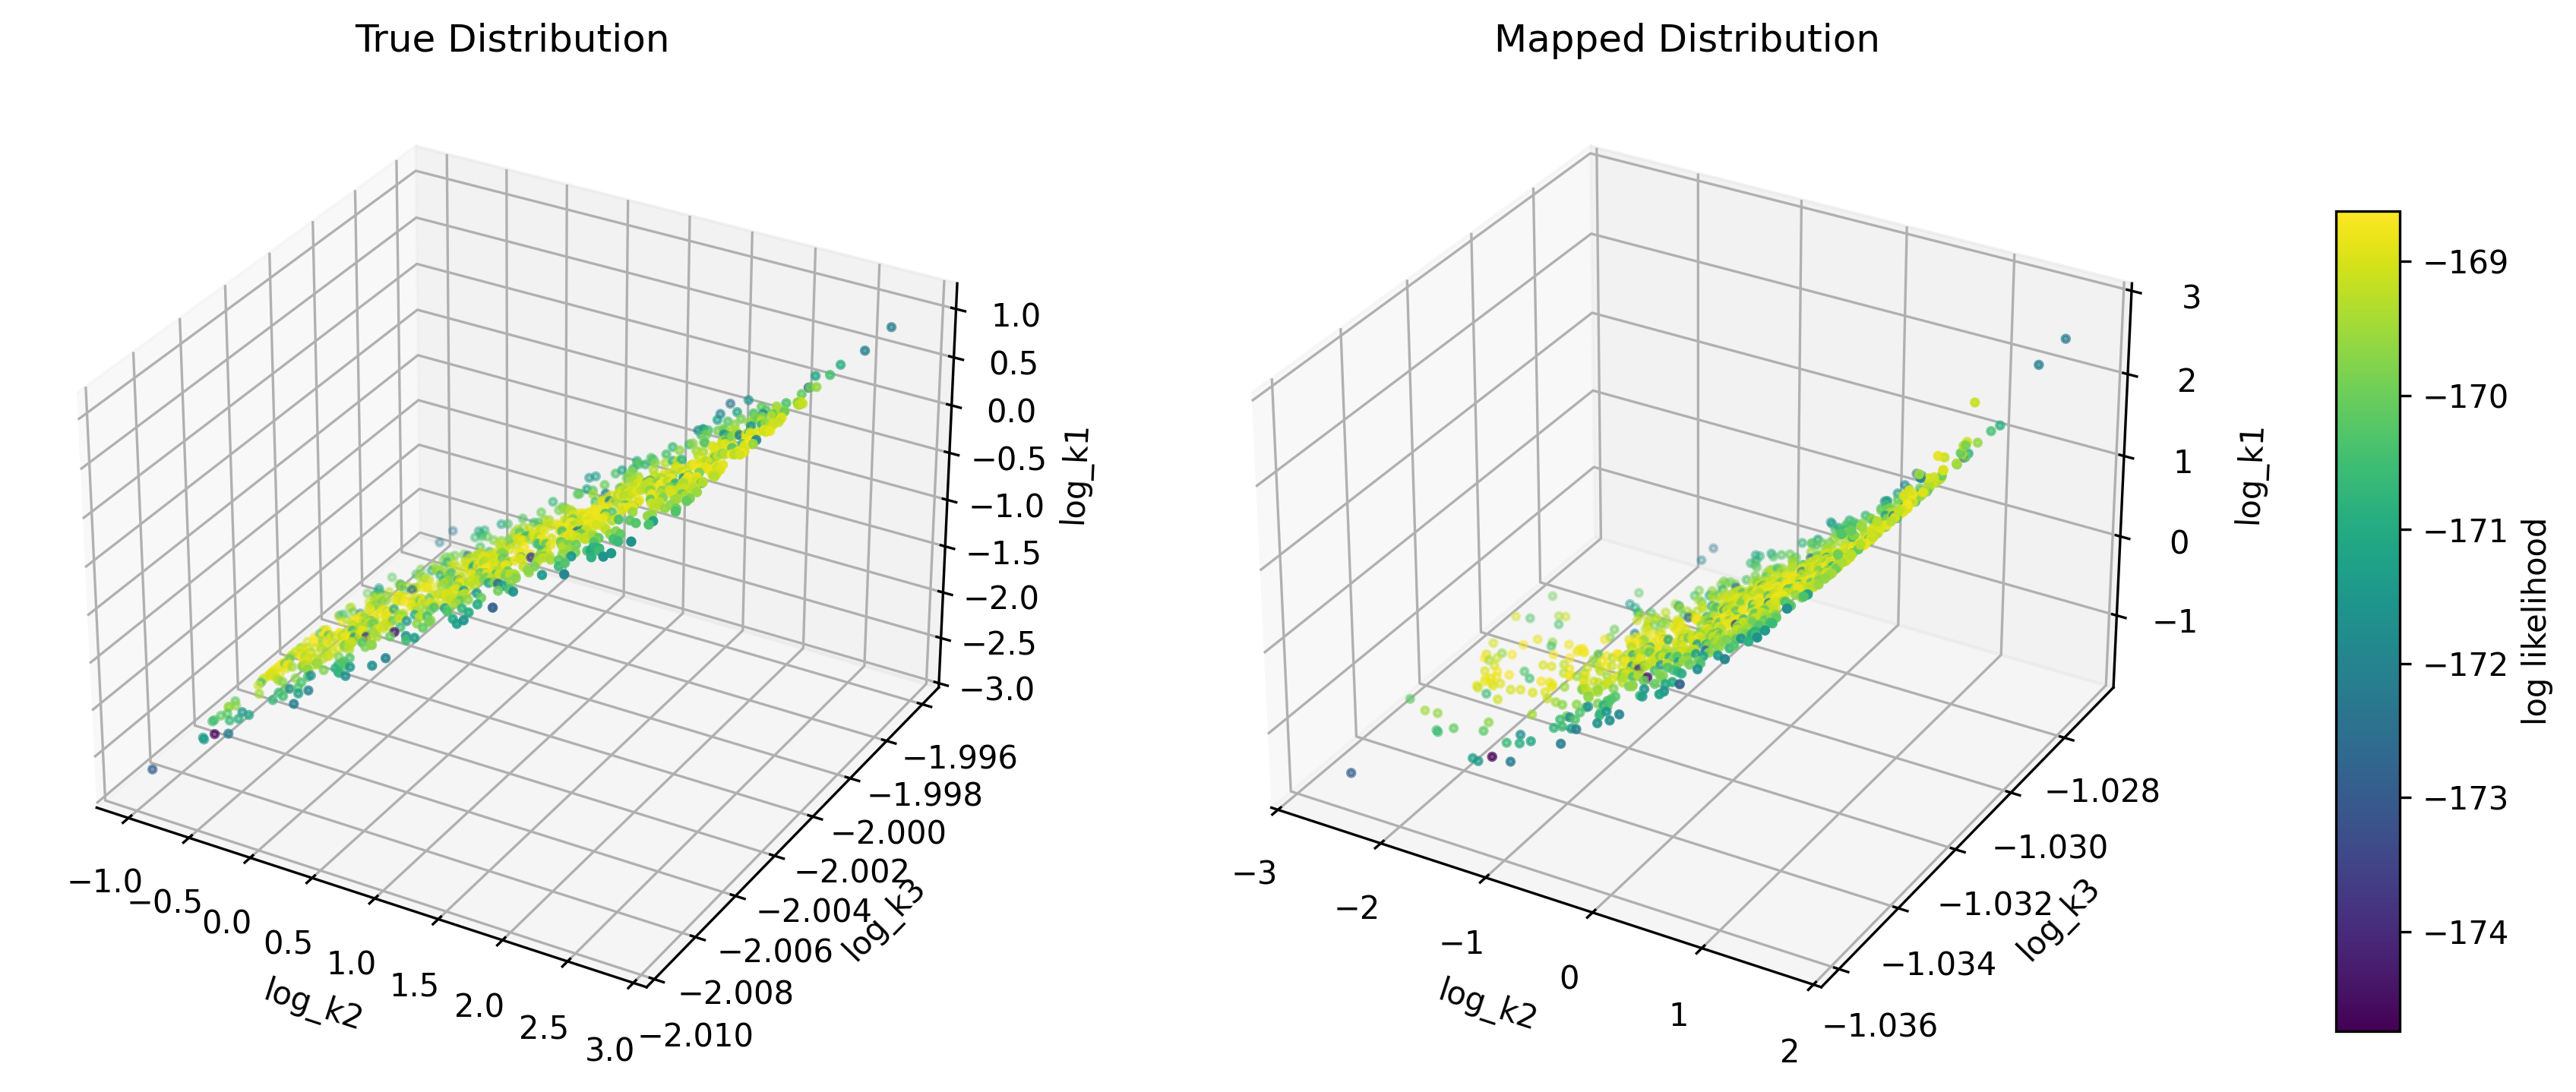

In [9]:

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d

fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

pmc_idx = methods.index("pmc")
pmc_best = best_results[pmc_idx]
u = pmc_best.algo_specific_info["u"]
gaussian_samps = u[-1, :, :]
pmc_samps = pmc_best.posterior_samples[:, :]
fig = plt.figure(figsize=(14,6), dpi=300)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.scatter3D(pmc_samps[:, 1], pmc_samps[:, 2], pmc_samps[:, 0],
				s=5, c=pmc_best.posterior_llhs, cmap="viridis")
ax1.set_xlabel(fit_par_names[1])
ax1.set_ylabel(fit_par_names[2])
ax1.set_zlabel(fit_par_names[0])
ax1.set_title("True Distribution")

g= ax2.scatter3D(gaussian_samps[:, 1], gaussian_samps[:,2], gaussian_samps[:, 0], 
				s=5, c=pmc_best.posterior_llhs, cmap="viridis")

ax2.set_xlabel(fit_par_names[1])
ax2.set_ylabel(fit_par_names[2])
ax2.set_zlabel(fit_par_names[0])
ax2.set_title("Mapped Distribution")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.6])
fig.colorbar(g, cax=cbar_ax, label="log likelihood", shrink=0.5)
#plt.colorbar(g, label="log likelihood", shrink=0.7)
#plt.tight_layout();
#plt.subplots_adjust(wspace=0.2)
plt.show();

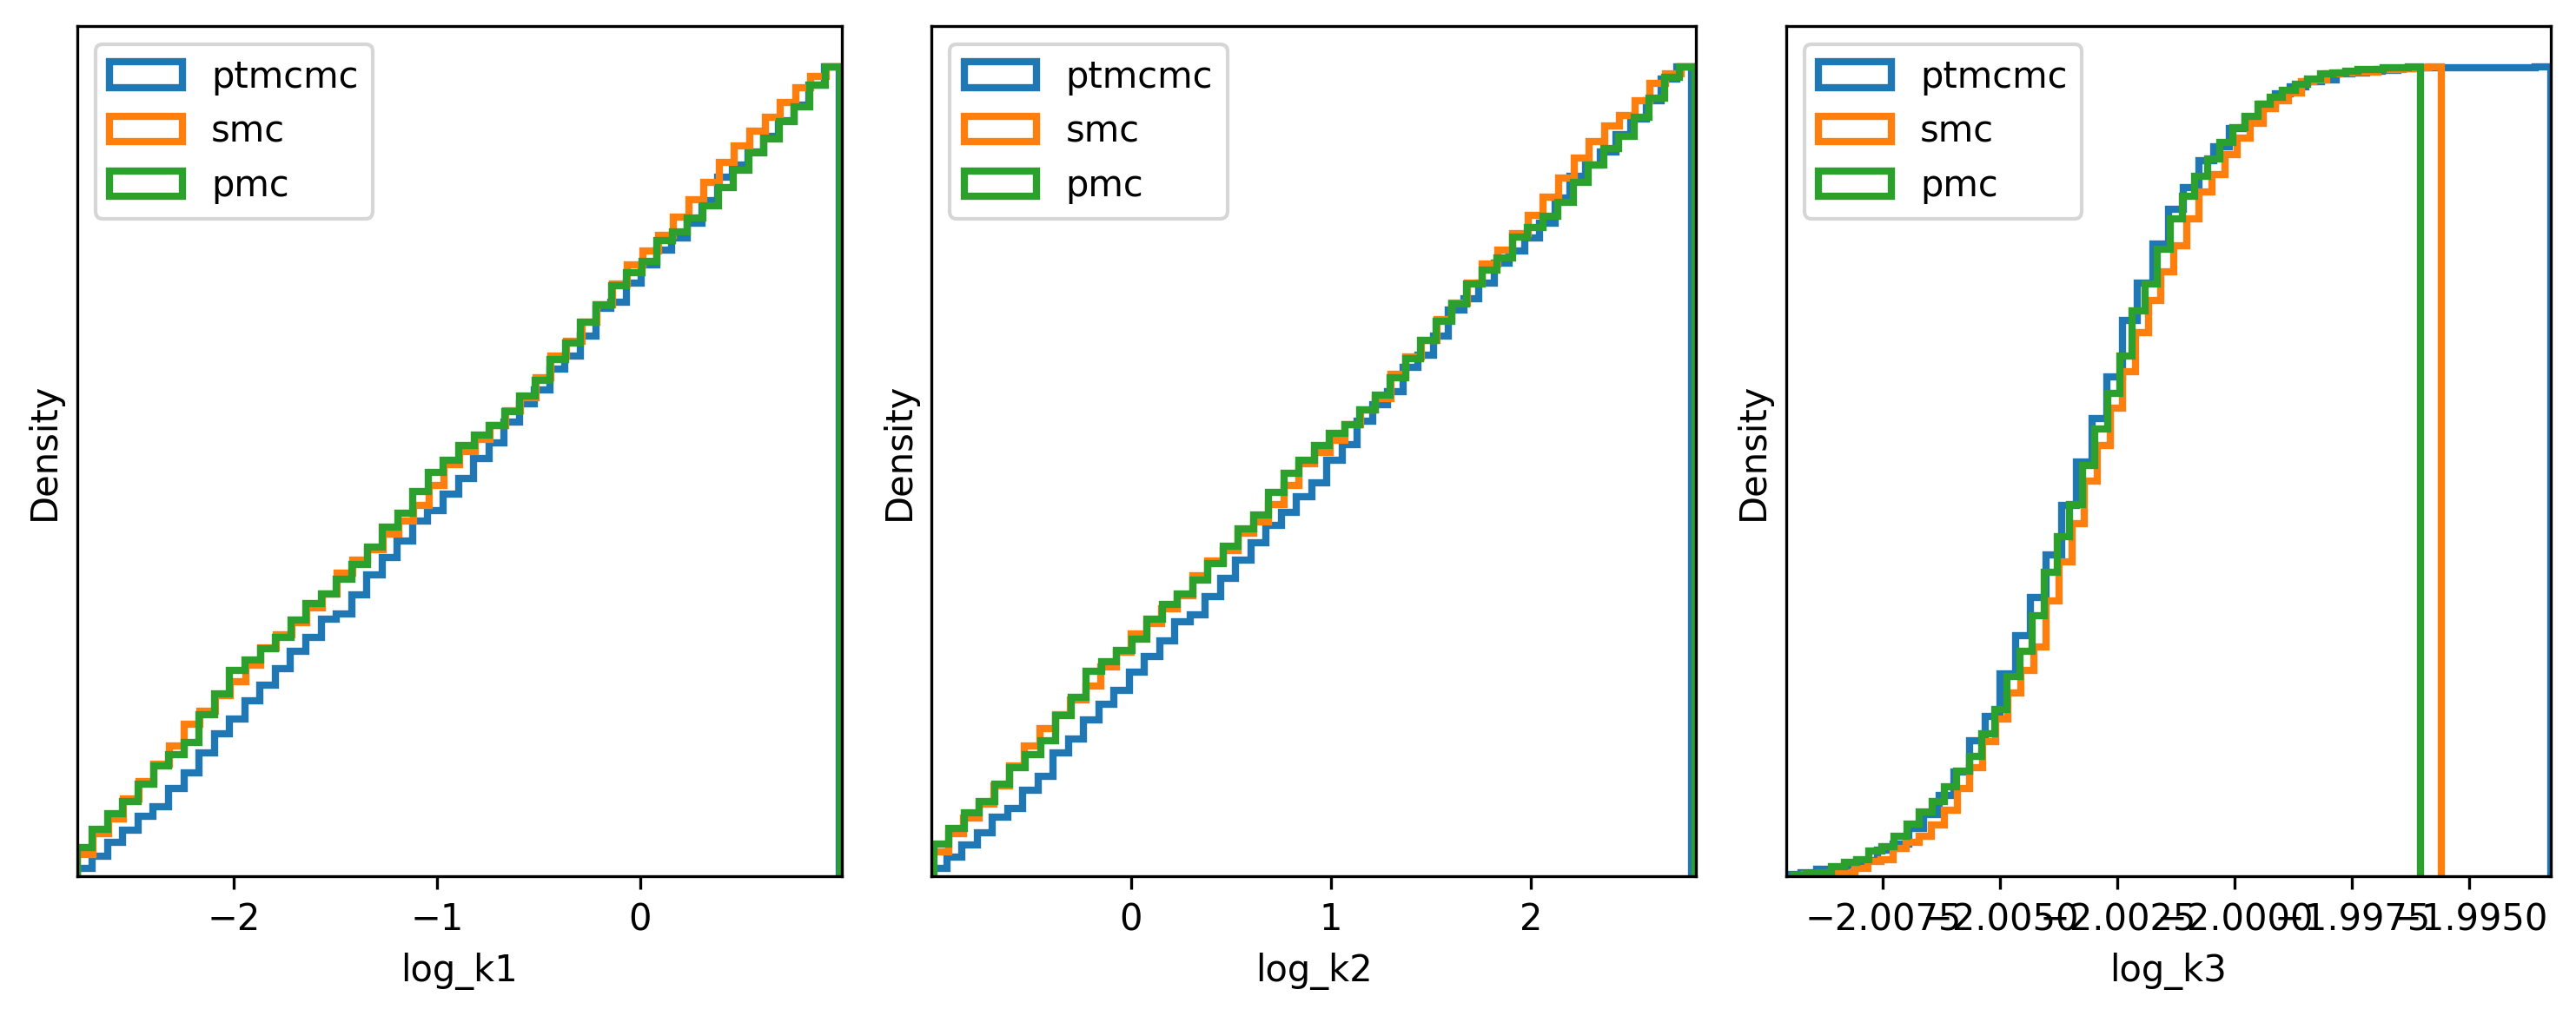

In [10]:
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

par_bounds = mod_prob.bounds
histtype = "step"
alpha=1

plt.figure(figsize=(10,4), dpi=300)
for i, par_name in enumerate(fit_par_names): 
	plt.subplot(int(f"1{mod_prob.n_dim}{i+1}"))
	for j in range(len(best_results)):      
		cur_result = best_results[j]
		norm_ws = cur_result.posterior_weights
		plt.hist(cur_result.posterior_samples[:, i], lw=2, weights=norm_ws, color=colors[j], alpha=alpha,
			 cumulative=True, histtype="step", bins=50, label=cur_result.method) 
		plt.xlabel(par_name)
		plt.yticks([])
		plt.ylabel("Density")
		plt.margins(x=0)
	plt.legend()
plt.tight_layout()

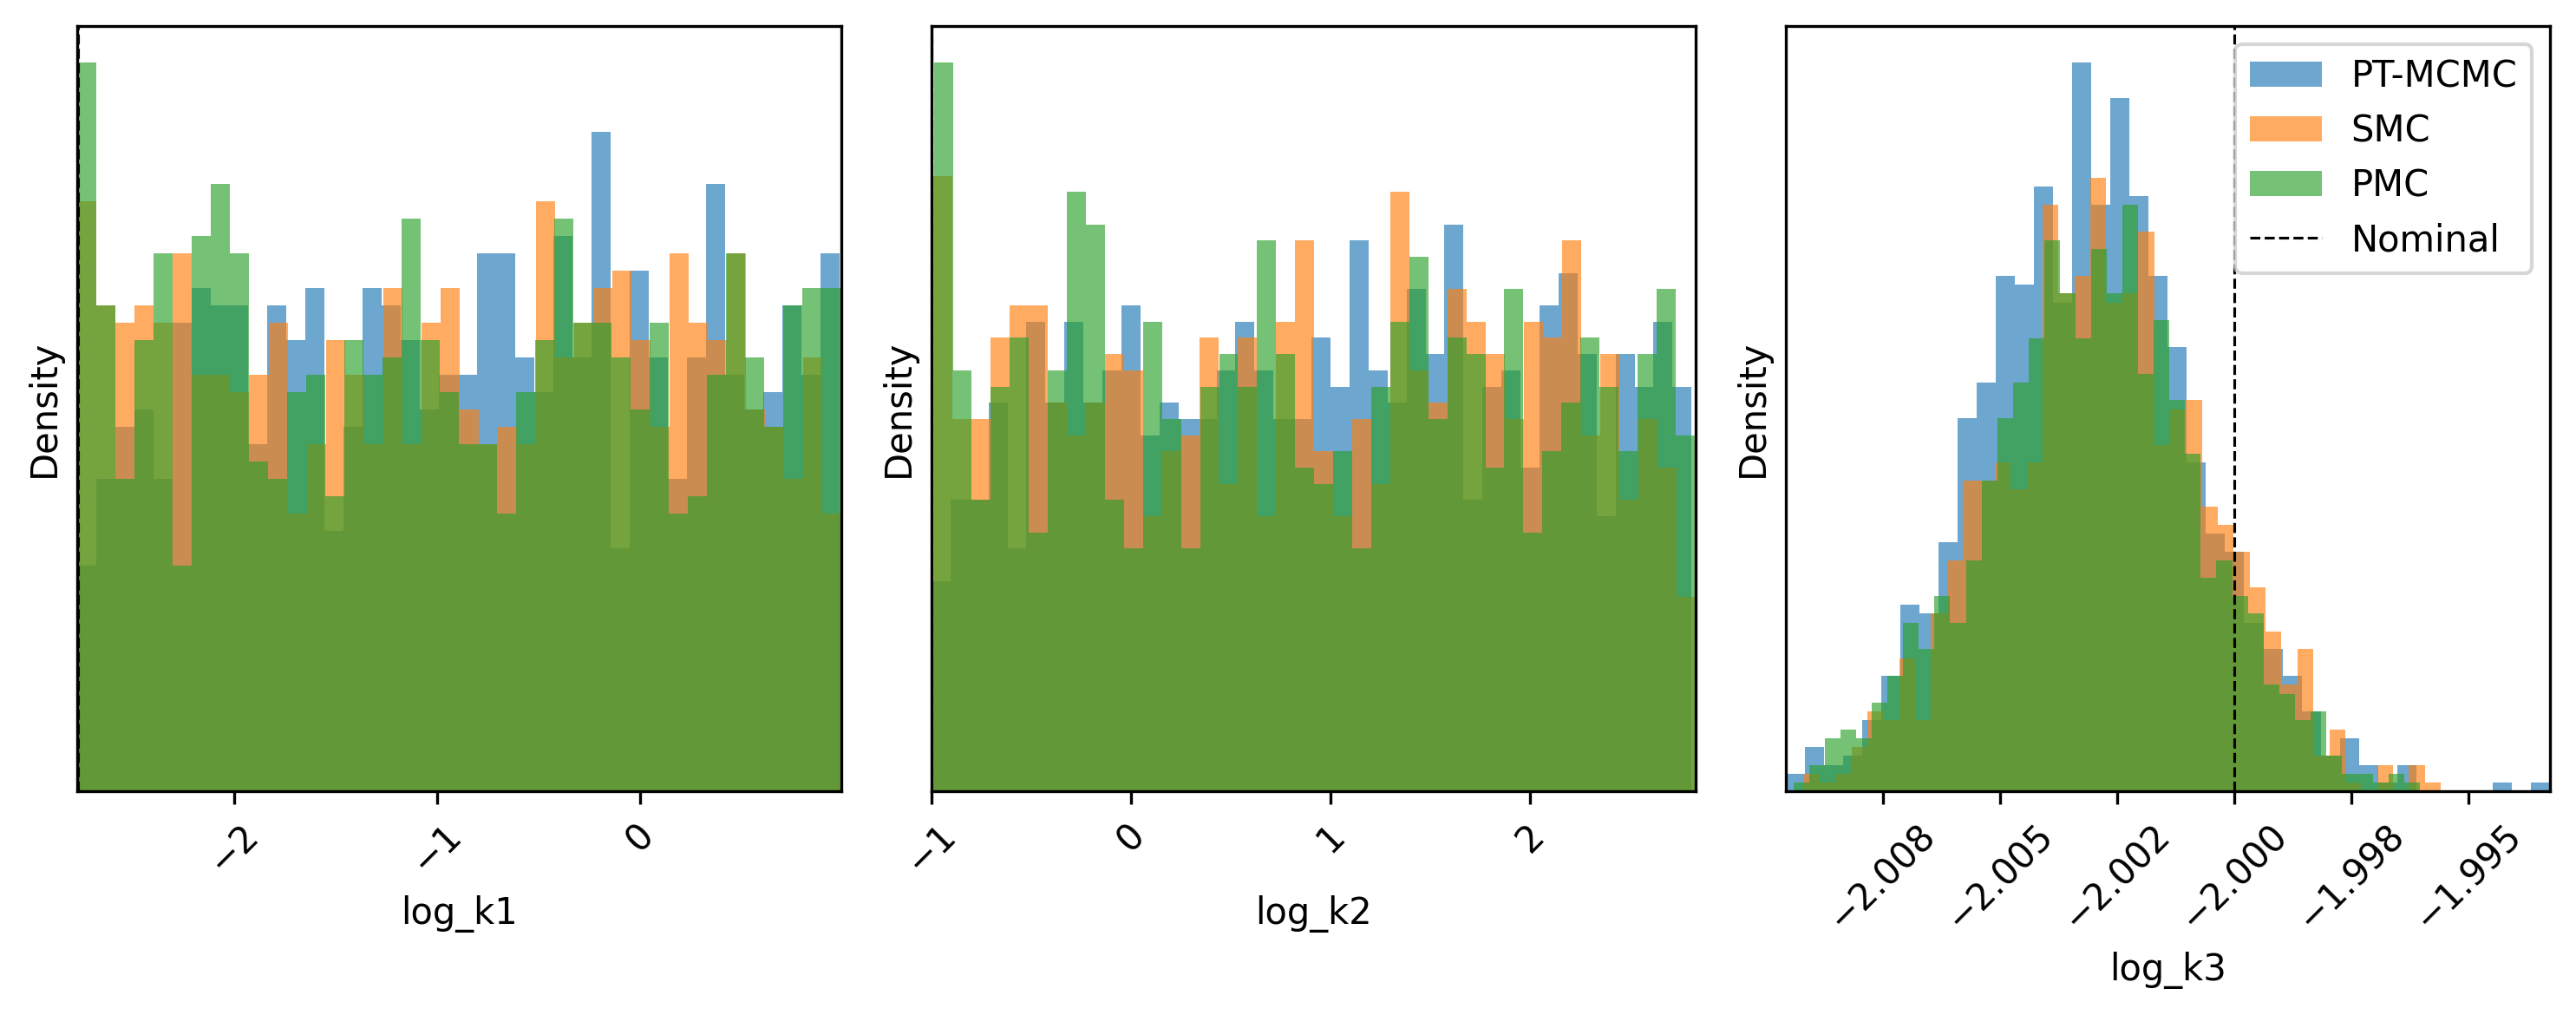

In [11]:
# Get the names of the estimated parameters
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

par_bounds = mod_prob.bounds
xtrue = mod_prob.petab_problem.get_x_nominal(fixed=False, scaled=False)
histtype = "bar"
alpha=0.65

plt.figure(figsize=(10,4), dpi=300)
for i, par_name in enumerate(fit_par_names): 
	plt.subplot(int(f"1{mod_prob.n_dim}{i+1}"))
	for j in range(len(best_results)):      
		cur_result = best_results[j]
		plt.hist(cur_result.posterior_samples[:, i], lw=2, weights=cur_result.posterior_weights, color=colors[j], alpha=alpha,
			 cumulative=False, histtype=histtype, bins=40, label=grouped_results[j].abbr) 
	#plt.axvline(x=xtrue[i], ls="--", color="k", label="Nominal", lw=0.75)
	plt.xlabel(par_name)
	plt.xticks(rotation=45)
	plt.yticks([])
	plt.ylabel("Density")
	plt.margins(x=0)
plt.legend()
plt.gca().xaxis.set_major_formatter("{x:.3f}")
#plt.xlim(left=par_bounds[i][0], right=par_bounds[i][1])

plt.tight_layout()

## Plot relationship between k1 and k2

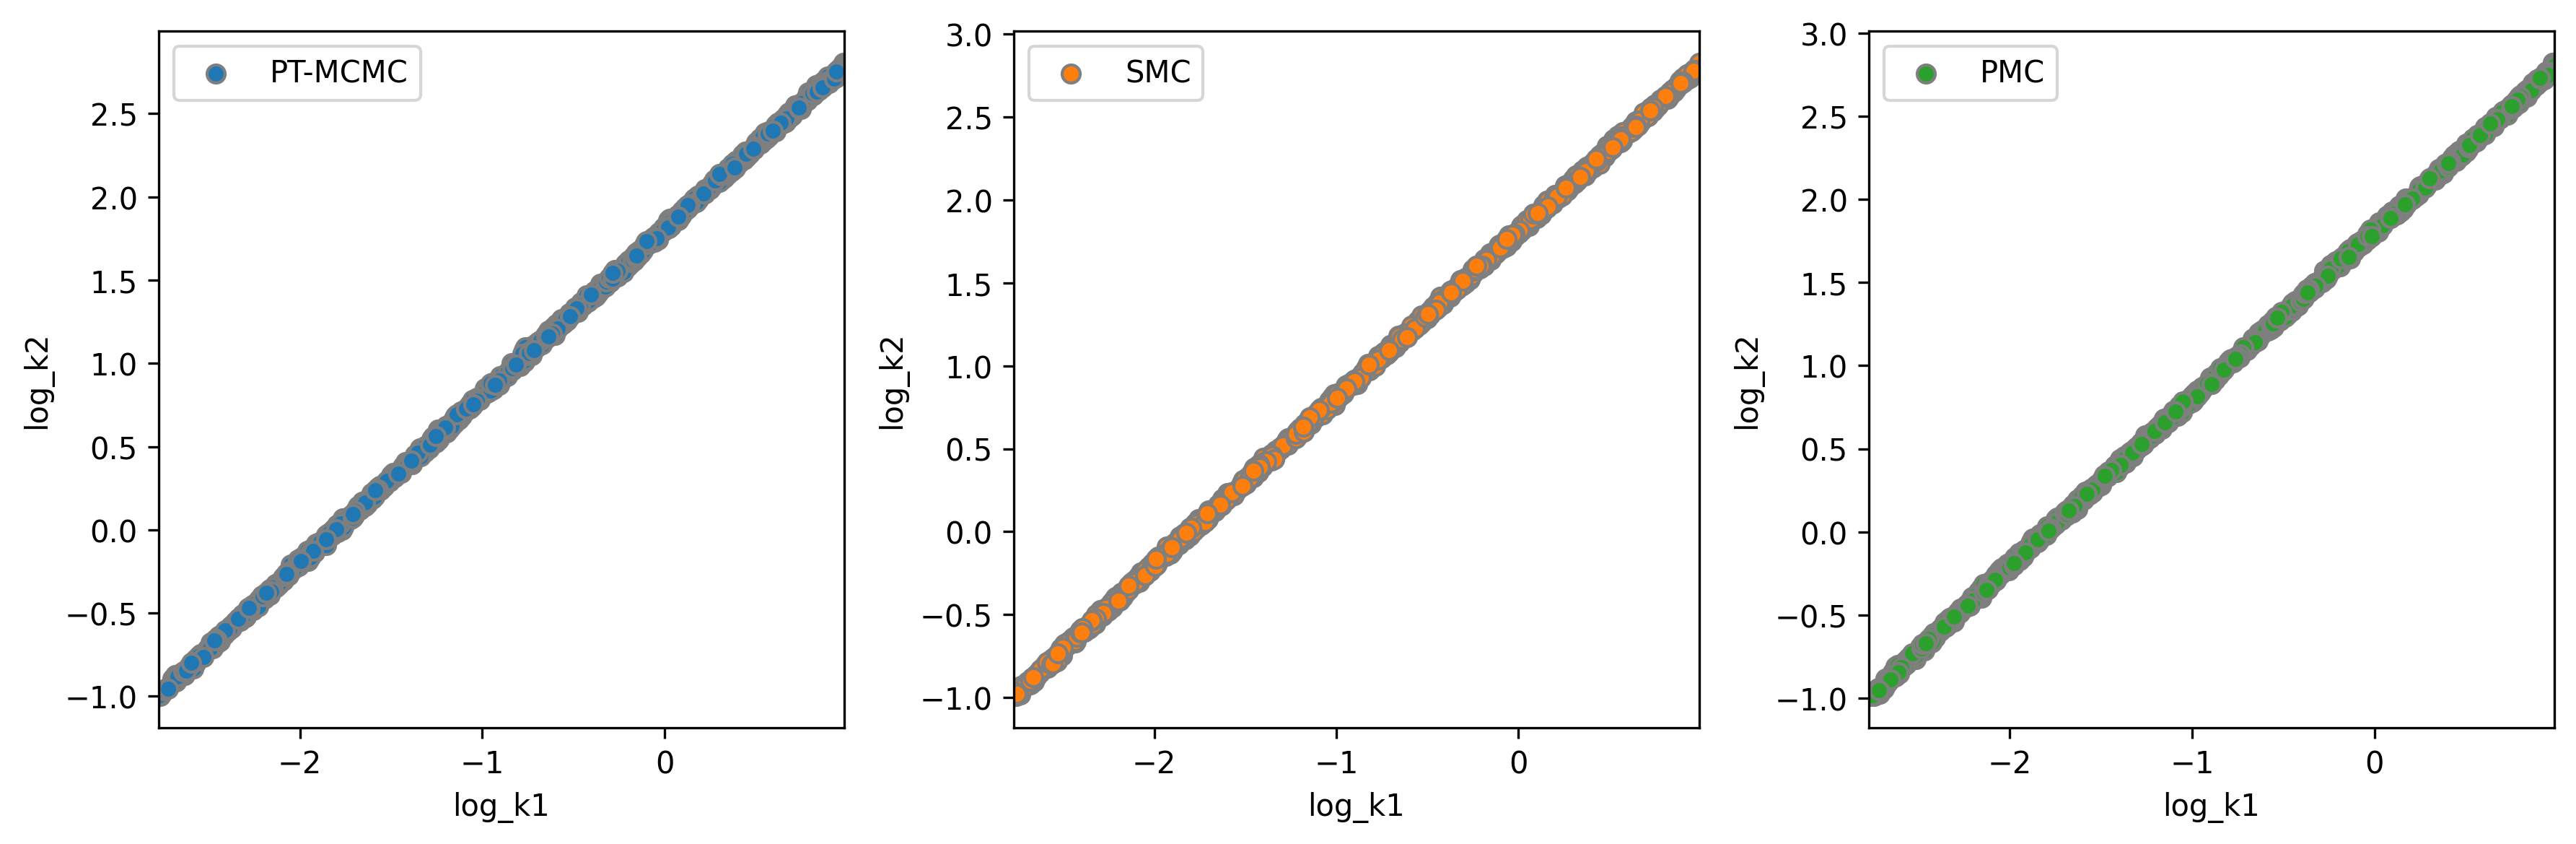

In [12]:
# Get the names of the estimated parameters
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

par_bounds = mod_prob.bounds
histtype = "bar"
alpha=0.65

plt.figure(figsize=(12,4), dpi=300)
for j in range(len(best_results)): 
	plt.subplot(int(f"1{len(methods)}{j+1}"))     
	cur_result = best_results[j]
	plt.scatter(cur_result.posterior_samples[:, 0], cur_result.posterior_samples[:, 1], marker="o", 
			 edgecolors="tab:gray", lw=1, facecolor=colors[j], label=grouped_results[j].abbr) 
	plt.xlabel("log_k1")
	plt.ylabel("log_k2")
	plt.margins(x=0)
	plt.legend()
#plt.gca().xaxis.set_major_formatter("{x:.3f}")
#plt.xlim(left=par_bounds[i][0], right=par_bounds[i][1])

plt.tight_layout()

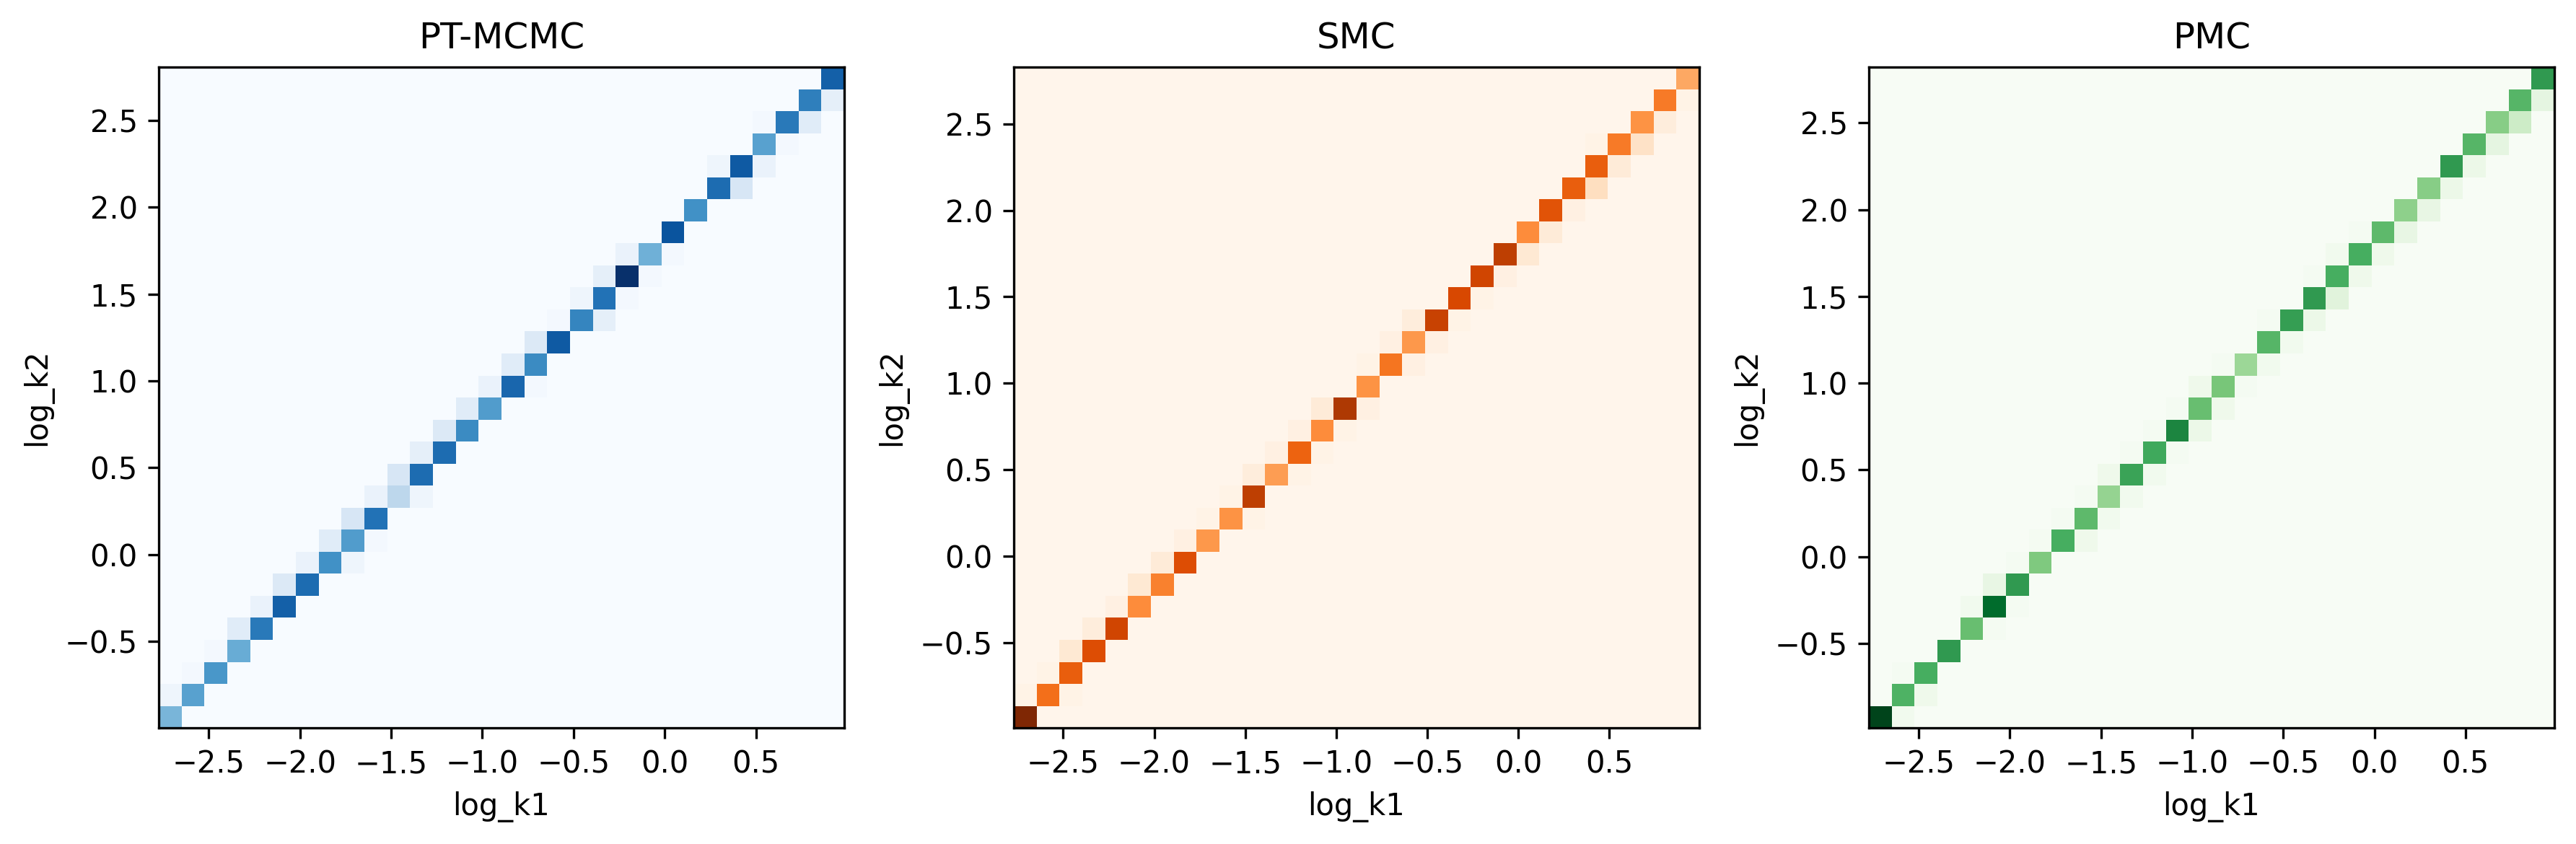

In [13]:
# Get the names of the estimated parameters
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

par_bounds = mod_prob.bounds

cmaps = ["Blues", "Oranges", "Greens"]
plt.figure(figsize=(12,4), dpi=300)
for j in range(len(best_results)): 
	plt.subplot(int(f"1{len(methods)}{j+1}"))     
	cur_result = best_results[j]
	plt.hist2d(cur_result.posterior_samples[:, 0], cur_result.posterior_samples[:, 1], bins=30, cmap=cmaps[j])
	plt.xlabel("log_k1")
	plt.ylabel("log_k2")
	plt.title(grouped_results[j].abbr)
	plt.gca().xaxis.set_major_locator(plt.MaxNLocator(9))
	plt.gca().yaxis.set_major_locator(plt.MaxNLocator(8))
#plt.gca().xaxis.set_major_formatter("{x:.3f}")
#plt.xlim(left=par_bounds[i][0], right=par_bounds[i][1])

plt.tight_layout()

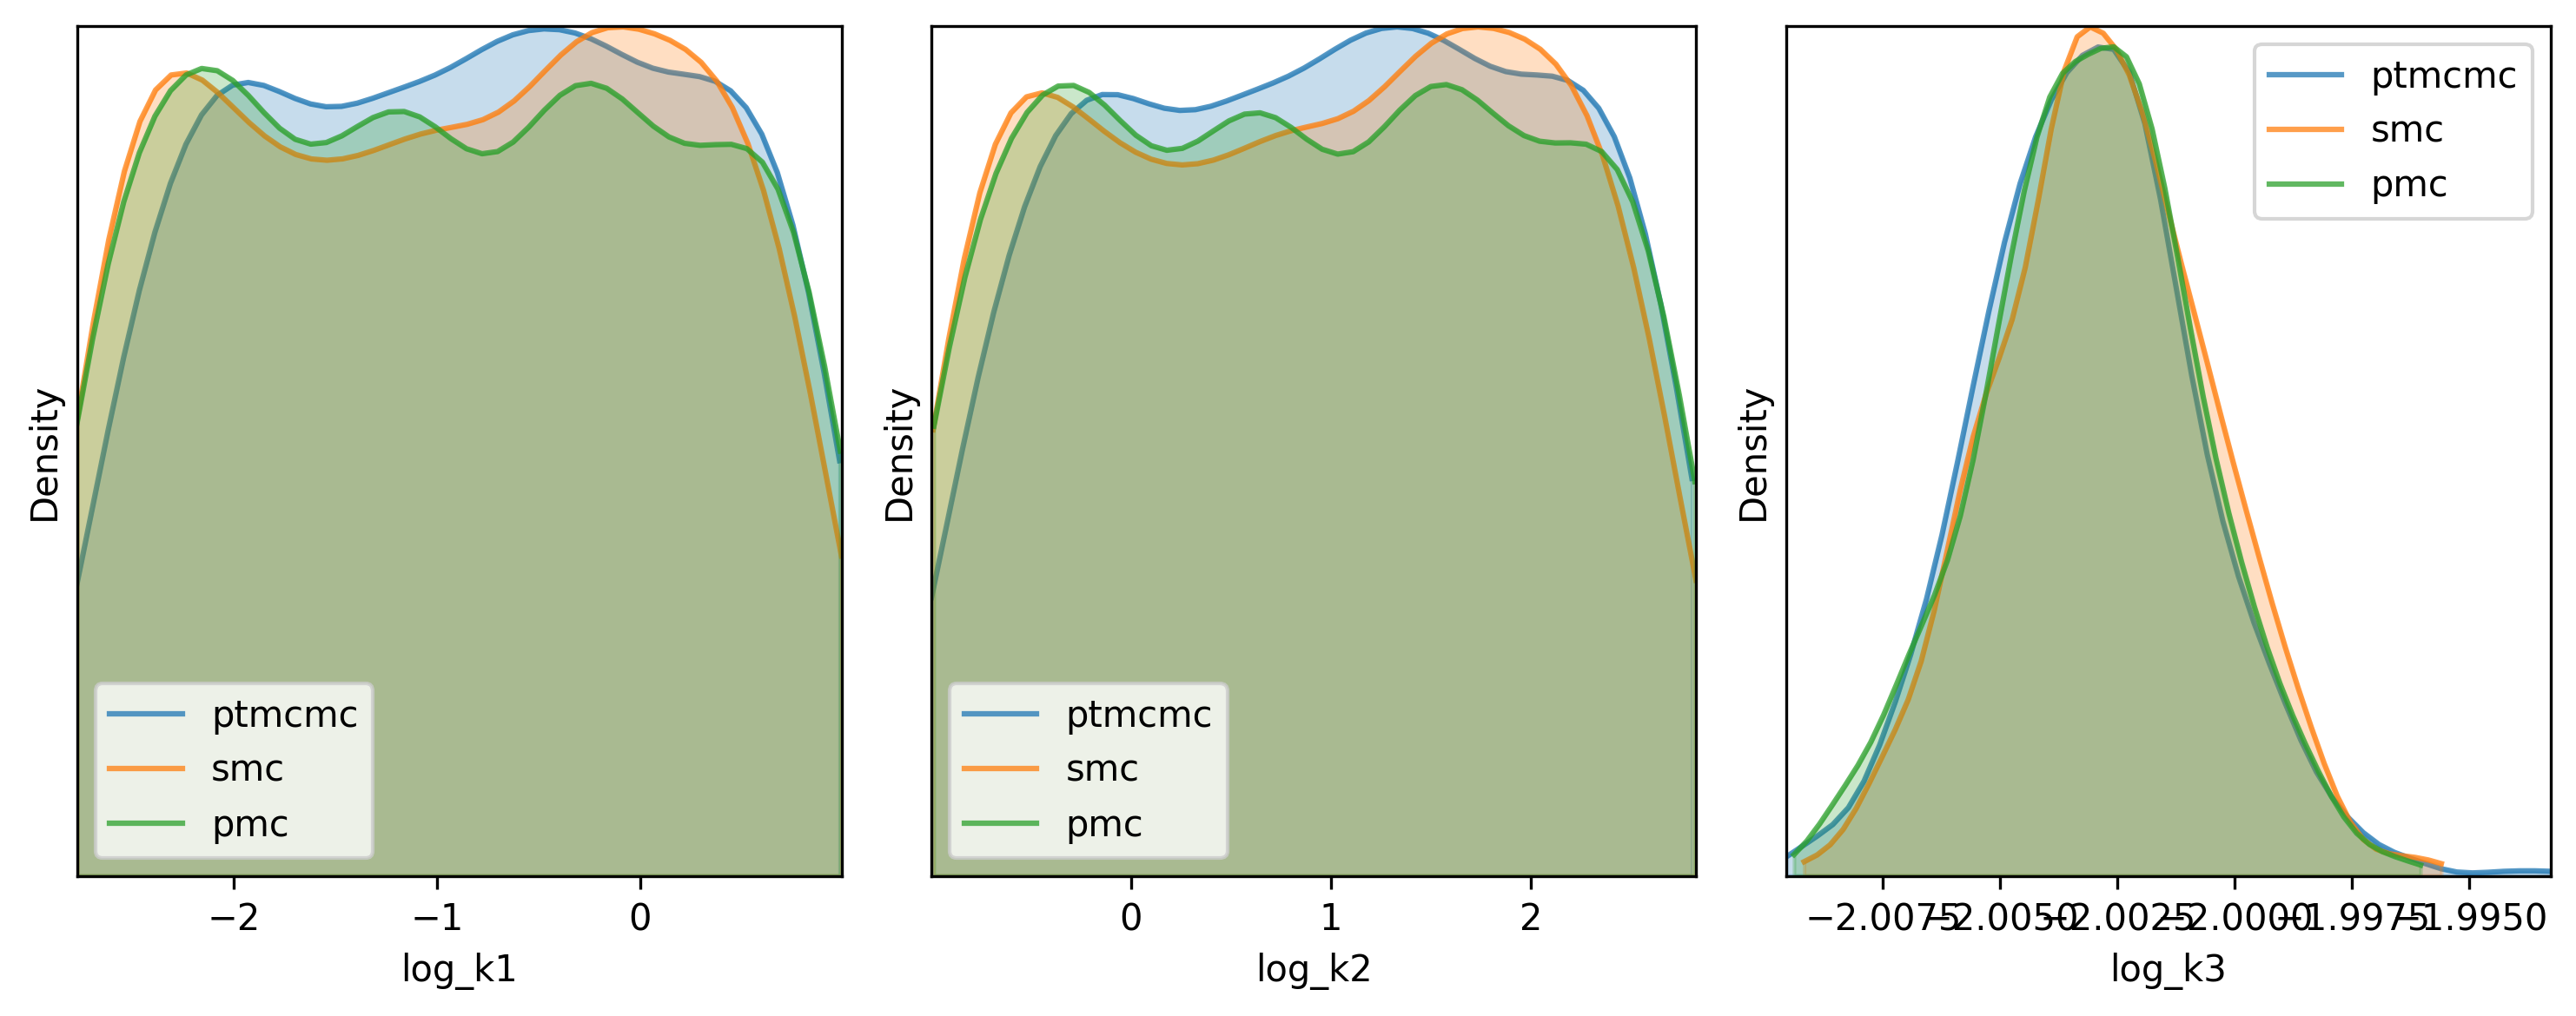

In [14]:
import scipy.stats as st
# Get the names of the estimated parameters
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

par_bounds = mod_prob.bounds
histtype = "bar"
alpha=0.5

plt.figure(figsize=(10,4), dpi=300)
for i, par_name in enumerate(fit_par_names): 
	plt.subplot(int(f"1{mod_prob.n_dim}{i+1}"))
	for j in range(len(best_results)):      
		cur_result = best_results[j]
		param_samples = cur_result.posterior_samples[:, i]
		norm_ws = cur_result.posterior_weights
		kde = st.gaussian_kde(param_samples, weights=norm_ws)
		x = np.linspace(np.min(param_samples), np.max(param_samples), 50)
		plt.plot(x, kde(x), '-', color=colors[j], alpha=0.75, zorder=1, label=cur_result.method)
		plt.fill_between(x, kde(x), alpha=0.25, color=colors[j], zorder=1)
		
		plt.xlabel(par_name)
		plt.yticks([])
		plt.ylabel("Density")
		plt.margins(x=0, y=0.001)
	plt.legend()
plt.tight_layout()

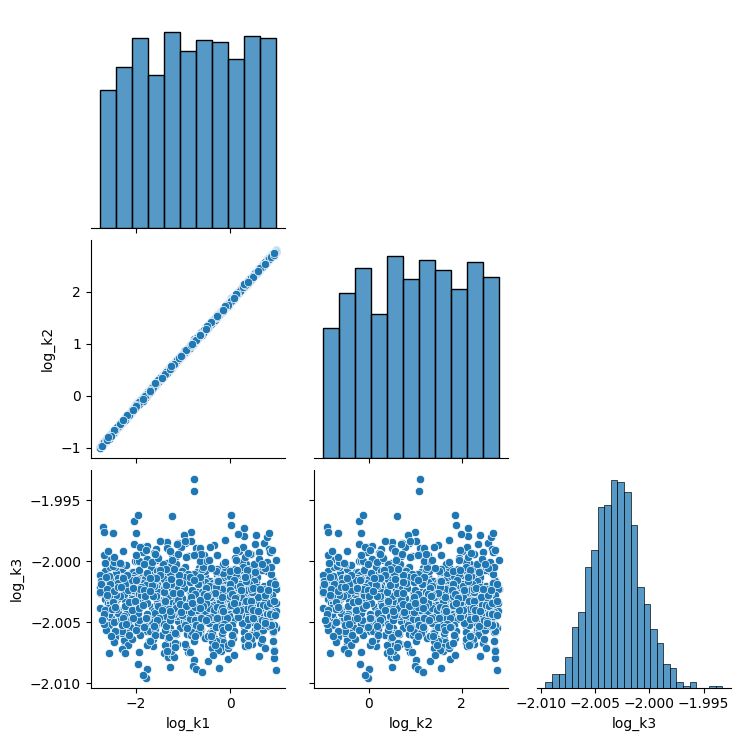

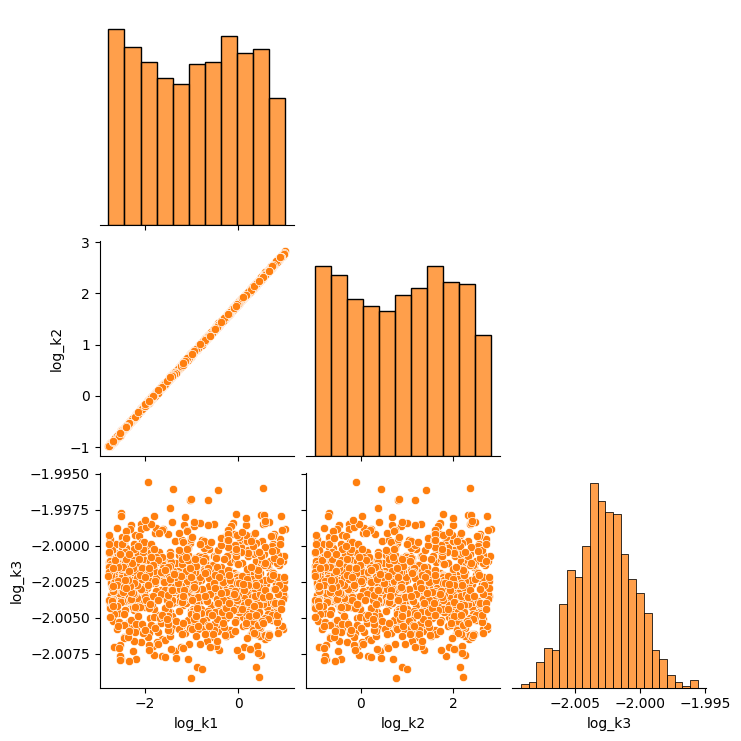

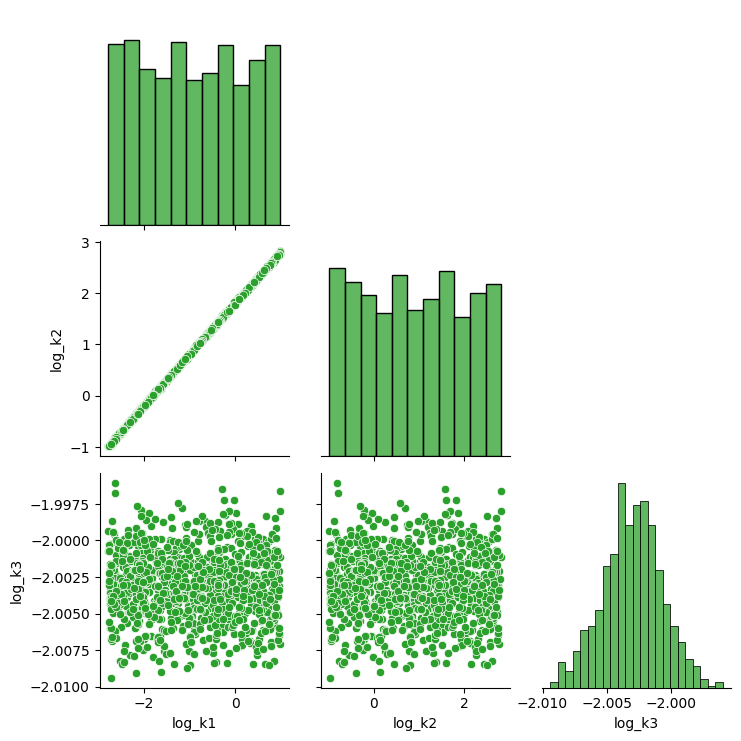

In [15]:
import corner
for i, method in enumerate(methods):
	cur_result = best_results[i]
	param_samples = cur_result.posterior_samples
	df = pd.DataFrame(data=param_samples, columns=fit_par_names)
	g = sns.pairplot(df, corner=True, diag_kws= {'color': colors[i]},
			  plot_kws={'color': colors[i]})

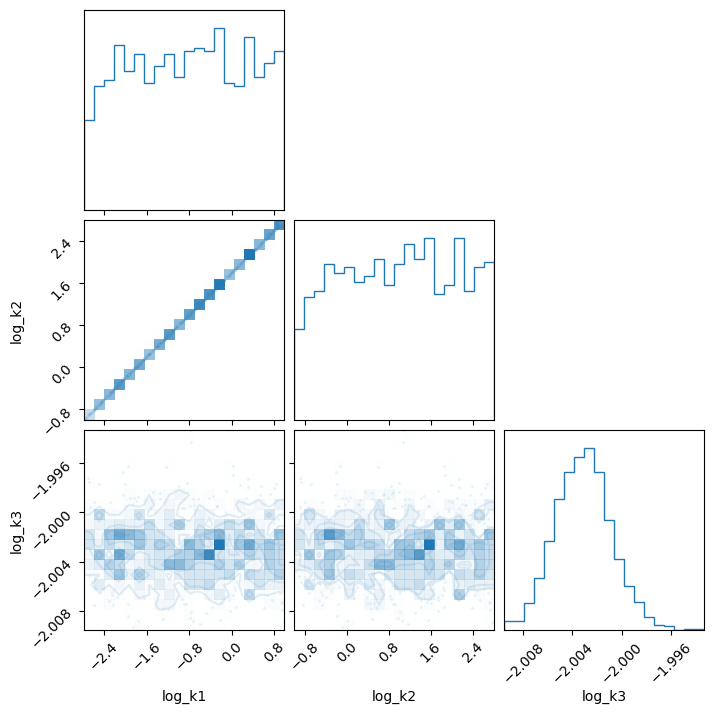

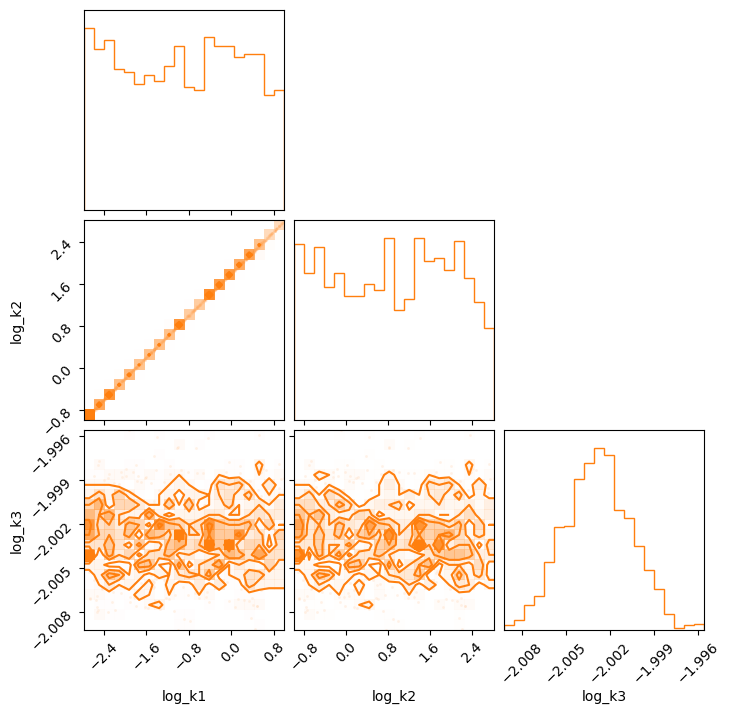

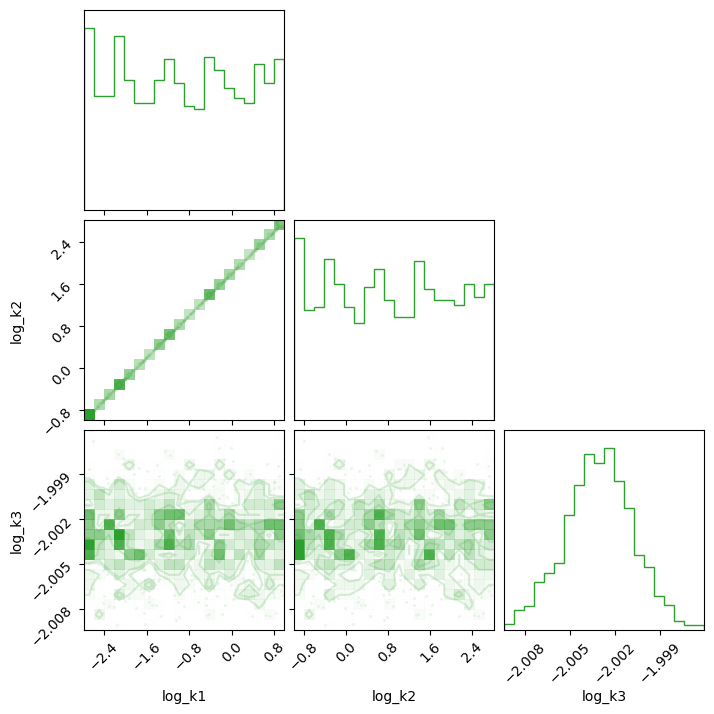

In [16]:
import corner
for i, method in enumerate(methods):
	cur_result = best_results[i]
	param_samples = cur_result.posterior_samples
	norm_ws = cur_result.posterior_weights #np.divide(cur_result.posterior_weights, np.sum(cur_result.posterior_weights))
	corner.corner(param_samples, weights=norm_ws, color=colors[i], labels=fit_par_names)
	

In [17]:
from pypesto.objective import AggregatedObjective
from pypesto.objective.roadrunner.road_runner import RoadRunnerObjective
obj = mod_prob.problem.objective

if isinstance(obj, AggregatedObjective):
    subobjs = mod_prob.problem.objective.__dict__["_objectives"]
    for subobj in subobjs:
        if isinstance(subobj, RoadRunnerObjective):
            obj = subobj
        else:
            continue

## Plot fits to model data

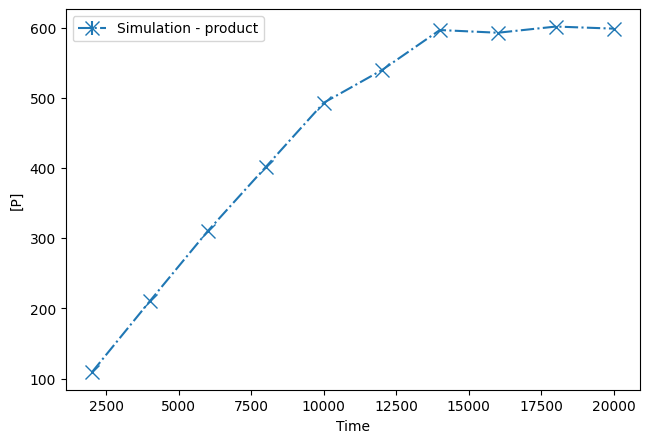

In [18]:
CI = 0.95
UPPER_PCT = (1 - (1-CI)/2)
LOWER_PCT = ((1-CI)/2)

petab_prob = mod_prob.petab_problem
ax_dict = plot_problem(petab_problem=petab_prob,) 
fig = plt.gcf()
# Change the figure size
fig.set_size_inches(6,4)

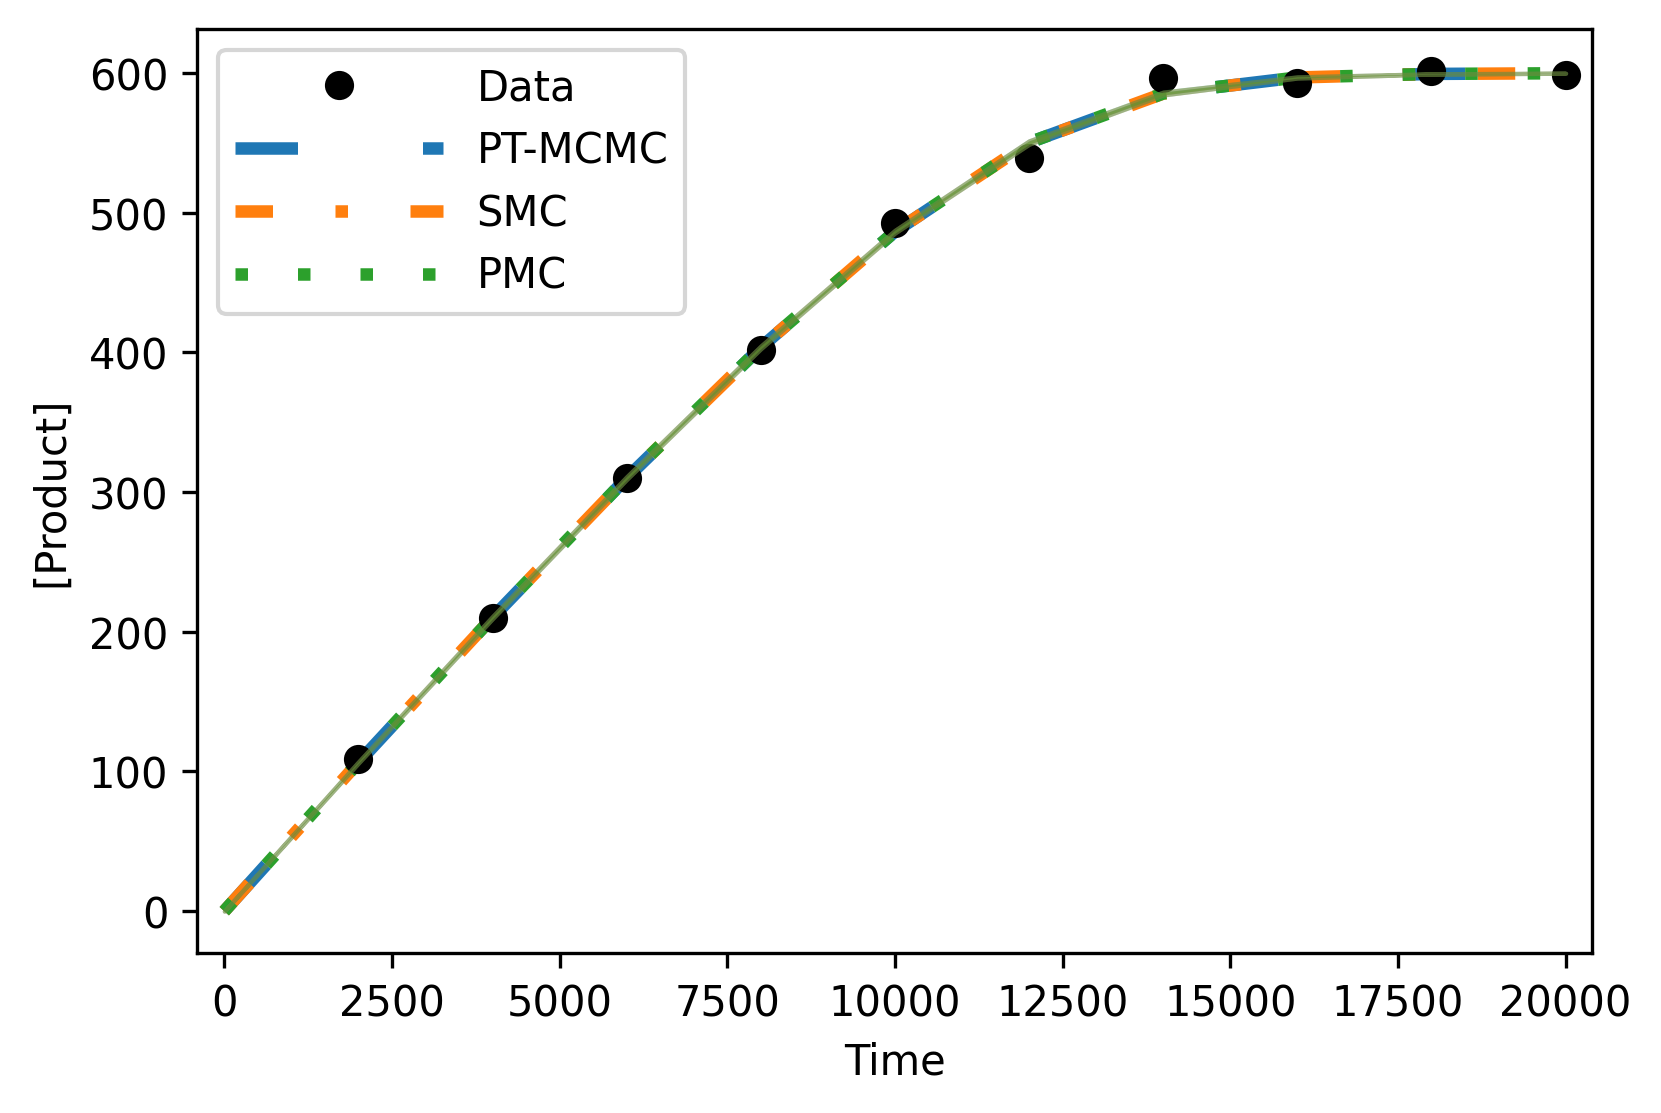

In [19]:
measure_df = petab_prob.measurement_df
plt.figure(figsize=(6,4), dpi=300)
plt.plot(measure_df["time"], measure_df["measurement"], "ko", label="Data", zorder=2)
lss = [(0,(5,10)), (0,(3,5,1,5)), (0,(1,4))]
for i, best in enumerate(best_results):
	pars = best.posterior_samples
	weights = best.posterior_weights

	all_sim_data = np.empty(shape=(measure_df.shape[0]+1, pars.shape[0]))

	## Collect all of the runs simulation information
	for n, par in enumerate(pars):
		sim = obj(par, mode="mode_fun", return_dict=True)["simulation_results"]["simCondition"]
		all_sim_data[:, n] = sim[:, 1]
		sim_ts = sim[:, 0]
		
	n_ts = len(sim_ts)
	mean_sim_data = np.average(all_sim_data, weights=weights, axis=1)
	temp = np.array([weighted_quantile(x, [LOWER_PCT, UPPER_PCT], weights) for x in all_sim_data])
	#print(temp[0])
	low_sim_data = temp[:, 0]
	high_sim_data = temp[:, 1]

	plt.plot(sim_ts, mean_sim_data, lw=3, linestyle=lss[i], label=grouped_results[i].abbr, zorder=1, color=colors[i])
	plt.fill_between(sim_ts, low_sim_data, high_sim_data, zorder=3, alpha=0.3, color=colors[i])
plt.legend(handlelength=5)
plt.margins(x=0.02)
plt.xlabel("Time"); plt.ylabel("[Product]");